In [4]:
from fenics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt

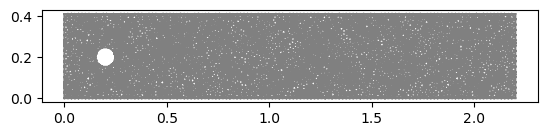

In [6]:
# Variables del problema y geometría
channel = Rectangle(Point(0, 0), Point(2.2, 0.41))
cylinder = Circle(Point(0.2, 0.2), 0.05)
domain = channel - cylinder

mesh = generate_mesh(domain, 64)

# Creamos una malla para la geometria dada
plot(mesh)

In [44]:
# Definimos los parámetros del experimento
T = 5.0  # Tiempo total de la simulación
num_steps = 500   # Número de puntos en la malla (uni-dimensional) de tiempo
# num_steps = 5000   # Número de puntos en la malla (uni-dimensional) de tiempo
dt = T / num_steps # longitud de cada intervalo de tiempo
mu = 0.001 # viscosidad dinámica
rho = 1  # densidad

In [45]:
# Definimos los espacios de funciones dónde buscaremos la solución
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

In [46]:
# Bordes geométricos
inflow   = 'near(x[0], 0)'    # flujo entrante
outflow  = 'near(x[0], 2.2)'  # flujo saliente
walls    = 'near(x[1], 0) || near(x[1], 0.41)' # paredes  
cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]> 0.1 && x[1]<0.3' # cilindro

In [47]:
# Definir el flujo entrante: 4*1.5*y*(0.41-y)/ 0.41^2
inflow_profile = ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0')

In [48]:
# Definir las condiciones de borde

# Para la función u
bcu_inflow   = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)  # en la entrada
bcu_walls    = DirichletBC(V, Constant((0, 0)), walls)  # en las paredes
bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)  # en el cilindro

# Para la función p
bcp_outflow = DirichletBC(Q, Constant(0), outflow)    # a la salida

bcu = [bcu_inflow, bcu_walls, bcu_cylinder]
bcp = [bcp_outflow]

In [49]:
# Definir las funciones de prueba y de busqueda
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

In [50]:
# Definir las funciones donde vivirás las soluciones
u_n = Function(V)
u_ = Function(V)
p_n = Function(Q)
p_ = Function(Q)

In [51]:
# Forma variacional para Navier-Stokes:

U = 0.5*(u_n + u)
n = FacetNormal(mesh)
f = Constant((0, 0))
k = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)
# Define tensor de deformaciones.
def epsilon(u):
    return sym(nabla_grad(u))

# Define tensor de esfuerzos
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))


# Forma variacional para el paso 1
F1 = rho*dot((u - u_n) / k, v)*dx \
+ rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
+ inner(sigma(U, p_n), epsilon(v))*dx \
+ dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
- dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Forma variacional para el paso 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Forma variacional para el paso 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

In [52]:
# Ensamblando las matrices que corresponden al operador a(u,v)
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

In [53]:
# Applicamos las condiciones de borde en cada parte de la geometría
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

[None]

In [54]:
# Exportamos las soluciones:

# Create XDMF files for visualization output
xdmffile_u = XDMFFile('navier_stokes_cylinder/velocity.xdmf')
xdmffile_p = XDMFFile('navier_stokes_cylinder/pressure.xdmf')
# Create time series (for use in reaction_system.py)
timeseries_u = TimeSeries('navier_stokes_cylinder/velocity_series')
timeseries_p = TimeSeries('navier_stokes_cylinder/pressure_series')
# Save mesh to file (for use in reaction_system.py)
File('navier_stokes_cylinder/cylinder.xml.gz') << mesh

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to read time series from file.
*** Reason:  Sample points for vector data are not strictly monotone in series "navier_stokes_cylinder/velocity_series".
*** Where:   This error was encountered inside TimeSeries.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.2.0.dev0
*** Git changeset:  unknown
*** -------------------------------------------------------------------------


In [57]:
# Guardar en forma de video:
# Time-stepping
t = 0
for n in range(num_steps):
    # Update current time
    t += dt
    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1, 'bicgstab', 'hypre_amg')
    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg')
    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3, 'cg', 'sor')
    # Plot solution
    plot(u_, title='Velocity')
    plot(p_, title='Pressure')
    # Save solution to file (XDMF/HDF5)
    xdmffile_u.write(u_, t)
    xdmffile_p.write(p_, t)
    # Save nodal values to file
    timeseries_u.store(u_.vector(), t)
    timeseries_p.store(p_.vector(), t)
    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)

    # Update progress bar
    # progress.update(t / T)
    # print('u max:', u_.vector().array().max())    
    print('u max:', u_.vector().max())    

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve linear system using PETSc Krylov solver.
*** Reason:  Solution failed to converge in 0 iterations (PETSc reason DIVERGED_NANORINF, residual norm ||r|| = 0.000000e+00).
*** Where:   This error was encountered inside PETScKrylovSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.2.0.dev0
*** Git changeset:  unknown
*** -------------------------------------------------------------------------


In [28]:
# Hold plot
# interactive()

NameError: name 'interactive' is not defined